In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [6]:
parse_dates = ['created_at']

In [7]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates, nrows=600000)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [9]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [10]:
df.isnull().sum()

order_id                   0
ride_id                    0
created_at                 0
pickup_lat               213
pickup_lon               213
dropoff_lat              293
dropoff_lon              293
user_id                75593
driver_id                  0
ride_distance              0
ooCancelReason             0
ooSuburbanDistance         0
ooCarSearchTime            0
ooCost                     0
ooExtraCost                0
ooInitialCost              0
ooIdleCost                 0
oapAzureMlCost        250951
oapAzureMlCostBid     250951
oapCostProvider       306045
ooSurgeMultiplier          0
driver_lat             72519
driver_lon             72519
dtTaxiDriver_tdID      72519
dtype: int64

In [11]:
df.shape

(600000, 24)

In [12]:
sample = df.sample(n=100)

In [13]:
sample.shape

(100, 24)

In [14]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id'],inplace=False)

In [15]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [16]:
new_df.shape

(505461, 24)

In [17]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost']]

In [18]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost
0,2017-10-31 23:59:59.143,9.10,0,13,115.0
1,2017-10-31 23:59:58.577,19.74,0,7,146.0
2,2017-10-31 23:59:55.050,11.08,0,1,100.0
3,2017-10-31 23:59:54.420,9.24,0,69,88.0
4,2017-10-31 23:59:50.053,3.73,0,4,55.0


In [19]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
dtype: int64

In [20]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [21]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [22]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter,month,day,dayofweek,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int
0,2017-10-31 23:59:59.143,9.10,0,13,115.0,4,10,31,1,23,4,10,31,1,23
1,2017-10-31 23:59:58.577,19.74,0,7,146.0,4,10,31,1,23,4,10,31,1,23
2,2017-10-31 23:59:55.050,11.08,0,1,100.0,4,10,31,1,23,4,10,31,1,23
3,2017-10-31 23:59:54.420,9.24,0,69,88.0,4,10,31,1,23,4,10,31,1,23
4,2017-10-31 23:59:50.053,3.73,0,4,55.0,4,10,31,1,23,4,10,31,1,23


In [23]:
data.shape

(505461, 15)

In [24]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter_int,month_int,day_int,dayofweek_int,hour_int
count,505461.000000,505461.0,505461.000000,505461.000000,505461.0,505461.0,505461.000000,505461.000000,505461.000000
mean,10.971786,0.0,18.494183,108.241914,4.0,10.0,22.393625,3.103523,13.428856
std,7.284152,0.0,28.640256,50.288912,0.0,0.0,5.383057,2.054529,6.620849
min,0.010000,0.0,-3528.000000,30.000000,4.0,10.0,13.000000,0.000000,0.000000
25%,5.480000,0.0,3.000000,71.000000,4.0,10.0,18.000000,1.000000,9.000000
50%,9.830000,0.0,9.000000,100.000000,4.0,10.0,22.000000,3.000000,14.000000
75%,14.460000,0.0,20.000000,130.000000,4.0,10.0,27.000000,5.000000,19.000000
max,115.590000,0.0,3485.000000,1350.000000,4.0,10.0,31.000000,6.000000,23.000000


In [25]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [26]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek']

In [27]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [28]:
# let's check
df_cat.head()

,quarter_4,month_10,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [29]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [30]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter,month,day,dayofweek,hour,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-31 23:59:59.143,9.10,0,13,115.0,4,10,31,1,23,...,0,0,1,0,1,0,0,0,0,0
1,2017-10-31 23:59:58.577,19.74,0,7,146.0,4,10,31,1,23,...,0,0,1,0,1,0,0,0,0,0
2,2017-10-31 23:59:55.050,11.08,0,1,100.0,4,10,31,1,23,...,0,0,1,0,1,0,0,0,0,0
3,2017-10-31 23:59:54.420,9.24,0,69,88.0,4,10,31,1,23,...,0,0,1,0,1,0,0,0,0,0
4,2017-10-31 23:59:50.053,3.73,0,4,55.0,4,10,31,1,23,...,0,0,1,0,1,0,0,0,0,0


In [31]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [32]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,hour,quarter_int,month_int,day_int,dayofweek_int,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-31 23:59:59.143,9.10,0,13,115.0,23,4,10,31,1,...,0,0,1,0,1,0,0,0,0,0
1,2017-10-31 23:59:58.577,19.74,0,7,146.0,23,4,10,31,1,...,0,0,1,0,1,0,0,0,0,0
2,2017-10-31 23:59:55.050,11.08,0,1,100.0,23,4,10,31,1,...,0,0,1,0,1,0,0,0,0,0
3,2017-10-31 23:59:54.420,9.24,0,69,88.0,23,4,10,31,1,...,0,0,1,0,1,0,0,0,0,0
4,2017-10-31 23:59:50.053,3.73,0,4,55.0,23,4,10,31,1,...,0,0,1,0,1,0,0,0,0,0


In [33]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int']

In [34]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [35]:
# split features and target
dfX = data.drop(['created_at','ooCost'], axis=1)
dfY = data['ooCost']

In [36]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,quarter_4,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.078647,0.0,0.504919,23,0.0,0.0,1.0,0.166667,23,1,...,0,0,1,0,1,0,0,0,0,0
1,0.170704,0.0,0.504064,23,0.0,0.0,1.0,0.166667,23,1,...,0,0,1,0,1,0,0,0,0,0
2,0.095778,0.0,0.503208,23,0.0,0.0,1.0,0.166667,23,1,...,0,0,1,0,1,0,0,0,0,0
3,0.079858,0.0,0.512905,23,0.0,0.0,1.0,0.166667,23,1,...,0,0,1,0,1,0,0,0,0,0
4,0.032185,0.0,0.503636,23,0.0,0.0,1.0,0.166667,23,1,...,0,0,1,0,1,0,0,0,0,0


In [37]:
dfY.head()

0    115.0
1    146.0
2    100.0
3     88.0
4     55.0
Name: ooCost, dtype: float64

In [38]:
# get features names
fNames = dfX.columns

In [39]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [40]:
X.shape, y.shape

((505461, 37), (505461,))

In [41]:
# Split our data into random train and test subsets with specific proportion (test size - 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [42]:
X_train.shape, y_train.shape

((379095, 37), (379095,))

### simple linear regression

In [43]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [44]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [46]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 363.67


In [47]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(y_test, y_pred)

11.576592672351227

### RandomForestRegressor

In [49]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [50]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

In [51]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 386.30


In [52]:
mean_absolute_percentage_error(y_test, y_pred)

12.072931514162425

### xgboost

In [53]:
xgb_model = xgb.XGBRegressor()

In [54]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
y_pred = xgb_model.predict(X_test)

In [56]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 341.07


In [57]:
mean_absolute_percentage_error(y_test, y_pred)

11.331873355408703

### LightGBM

In [58]:
lgb_model = lgb.LGBMRegressor(objective='mape')

In [59]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective='mape', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [60]:
y_pred = lgb_model.predict(X_test)

In [61]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 435.49


In [62]:
mean_absolute_percentage_error(y_test, y_pred)

9.254741027025638

In [63]:
# lightgbm usually faster than xgboost (and in our case also)

In [64]:
# next step - tuning models hyperparameters for better result

### ExtraTreesRegressor

In [65]:
etr = ExtraTreesRegressor(random_state=1)

In [66]:
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [67]:
y_pred = etr.predict(X_test)

In [68]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 458.81


In [69]:
mean_absolute_percentage_error(y_test, y_pred)

12.690827261775892

### Tunning

In [70]:
estimator = lgb.LGBMRegressor(objective='mape', random_state=1)

In [71]:
# Dictionary with parameters names as keys and lists of parameter settings to try as values fro tunning
param_grid = {
    'num_leaves': [35,40,45],
    'learning_rate': [0.1, 0.15,0.2],
    'n_estimators': [200,250,300]
}

In [72]:
# prepare search over specified parameter values for an estimator
gscv = GridSearchCV(estimator, param_grid, cv=5)

In [73]:
# Run fit with all sets of parameters using the training sets
gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 250, 300], 'learning_rate': [0.1, 0.15, 0.2], 'num_leaves': [35, 40, 45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [74]:
print(gscv.best_score_)

0.829316786679323


In [75]:
print(gscv.best_params_)

{'n_estimators': 300, 'learning_rate': 0.2, 'num_leaves': 45}


In [76]:
y_pred = gscv.predict(X_test)

In [77]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 415.74


In [78]:
mean_absolute_percentage_error(y_test, y_pred)

9.126025769810461

In [79]:
# 9.930478326132278

In [80]:
feature_importances = gscv.best_estimator_.feature_importances_

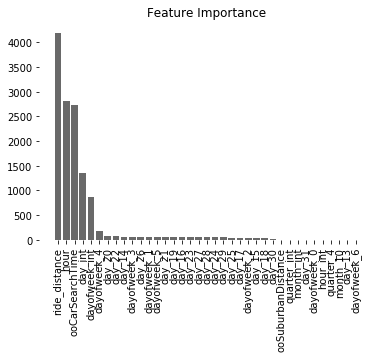

In [84]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [85]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

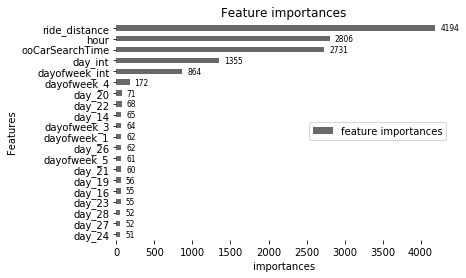

In [86]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()